In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
texts = [
    "My break lasts from 40 to 50 minutes, and I take around 10 and a half minutes to eat a lunch, how much time do I have left to rest?",
    "If the bus takes about 4 minutes to get to the station and around 5 to 8 minutes to get from the station to the university, how many minutes will it take me to get to the university?",
    "If I leave the university around 7 o'clock and it takes me about 1 hour to get home, what time will I be home?",
    "My break lasts between 40 to 50 minutes, and I take 20 to 30 minutes to eat lunch, how much time do I have left to rest?",
    "If I do an activity between 3 and 4 hours and then run between 1 and 2 hours, how many hours of activity did I do in total?",
    "If I have about 3 hours free and of those I use about 1 hour to watch a movie, how much free time do I have left?",
    "I have between 4 to 5 hours to do my homework, but I want to watch a video that lasts about 1 hour. How much time would I have left to do my homework?",
    "If a series has about 6 chapters that last about 30 minutes each, how long is the whole series?",
    "Printing one worksheet takes around 3 minutes. If I have to print 5 to 8 sheets, how many minutes will it take me to print all the sheets?",
    "I take between 5 and 10 minutes to finish a reading check and I have between 1 and 3 reading checks. How long will it take me to do all the reading checks?",
    ######
    "If an oven takes about 5 minutes to preheat and 6 to 9 minutes to bake cookies, how long in total does it take to get the cookies ready?",
    "If I boil a dish around 6 o'clock and it takes approximately 50 minutes to be ready, at what time will it be ready?",
    "If my exercise routine consists of 30 to 40 minutes of cardio and 20 to 30 minutes of hypertrophy, how many minutes of activity did I do in total?",
    "My break lasts between 45 and 55 minutes, and I take between 15 and 25 minutes for lunch. How much time do I have left to rest?",
    "If I have about 3 hours to do a homework submission, but I have to do a reading check that takes about 1 hour, how much time do I have left to complete my homework?",
    "I have 3 to 4 hours to finish a project, but I want to help myself with the class recording, which takes about 1 hour. How much time would I have left to finish the project?",
    "Today I had 3 classes that last about 30 minutes each. How many minutes of classes did I have today?",
    "Solving an exercise takes me about 4 minutes. If the lesson will have between 6 and 9 exercises, how many minutes will it take me to finish the lesson?",
    "It takes me between 7 and 12 minutes to write a paragraph. If I have to write between 1 and 3 paragraphs for the introduction of an activity, how long will it take me to write the introduction?",
    ######
    "If the train takes 3 to 6 minutes to get to the stop, and 10 to 15 minutes to get from the stop to the mall, how many minutes will it take me to get to the mall?",
    "If I leave work around 5 PM and it takes me no more than 45 minutes to get home, what time will I be home?",
    "My warm-up lasts between 5 to 7 minutes and I do at least 45 minutes of exercise. How long does my routine last?",
    "I want to watch at least 6 chapters of a series where each chapter lasts between 20 to 25 minutes, for how many minutes will I be watching the series?",
    "If you are going to send me a math homework assignment that will have 5 to 7 exercises and I assume that I will take 10 to 15 minutes for each exercise, how long will it take me to finish my homework?",
    "I want to read books for at least 30 minutes a day and at least 4 days a week. How many minutes will I read per week?",
    "I am leaving for work in 50 to 70 minutes, and it takes me 35 to 45 minutes to get ready. How much time do I have to eat my breakfast?",
    "I have about 50 minutes to eat, but it takes me 35 to 40 minutes to cook, how long will I have to eat?",
    "I have about 70 minutes to submit my homework and it will take me at least 50 minutes to complete it. How much time will I have to submit the homework?",
    "I have 60 to 70 minutes free to rest, but I want to clean my room. If I spend 30 to 45 minutes cleaning my room, how much time will I have to take a nap?"
]
labels = [
    1,
    0,
    0,
    1,
    0,
    1,
    1,
    2,
    2,
    2,
    ######
    0,
    0,
    0,
    1,
    1,
    1,
    2,
    2,
    2,
    ######
    0,
    0,
    0,
    2, 
    2,
    2, 
    1,
    1,
    1,
    1
]  # 0: addition, 1: subtraction, 2: multiplication

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=418, stratify=labels)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def encode_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

train_encodings = encode_texts(train_texts)
test_encodings = encode_texts(test_texts)

# Create datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 10  # 10 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function
def train_model(model, train_dataloader, optimizer, scheduler, device, num_epochs=10):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average training loss: {avg_train_loss:.4f}")
        
        # Save the best model
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'f_arith_clf.pth')
            print(f"Model saved at epoch {epoch+1} with loss: {best_loss:.4f}")

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            true_labels.extend(labels.cpu().tolist())
            predicted_labels.extend(preds.cpu().tolist())
    
    report = classification_report(true_labels, predicted_labels, target_names=['addition', 'subtraction', 'multiplication'])
    return report, true_labels, predicted_labels

# Training
train_model(model, train_dataloader, optimizer, scheduler, device)

Epoch 1/10, Average training loss: 0.5159
Model saved at epoch 1 with loss: 0.5159
Epoch 2/10, Average training loss: 0.4643
Model saved at epoch 2 with loss: 0.4643
Epoch 3/10, Average training loss: 0.4725
Epoch 4/10, Average training loss: 0.4117
Model saved at epoch 4 with loss: 0.4117
Epoch 5/10, Average training loss: 0.3689
Model saved at epoch 5 with loss: 0.3689
Epoch 6/10, Average training loss: 0.3815
Epoch 7/10, Average training loss: 0.3409
Model saved at epoch 7 with loss: 0.3409
Epoch 8/10, Average training loss: 0.3104
Model saved at epoch 8 with loss: 0.3104
Epoch 9/10, Average training loss: 0.3187
Epoch 10/10, Average training loss: 0.2964
Model saved at epoch 10 with loss: 0.2964


In [18]:
# Load the best model
checkpoint = torch.load('f_arith_clf.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with loss: {checkpoint['loss']:.4f}")

Loaded best model from epoch 10 with loss: 0.2964


In [19]:
# Evaluation
test_report, true_labels, predicted_labels = evaluate_model(model, test_dataloader, device)
print("Test set performance:")
print(test_report)

Test set performance:
                precision    recall  f1-score   support

      addition       0.75      1.00      0.86         3
   subtraction       1.00      1.00      1.00         3
multiplication       1.00      0.67      0.80         3

      accuracy                           0.89         9
     macro avg       0.92      0.89      0.89         9
  weighted avg       0.92      0.89      0.89         9



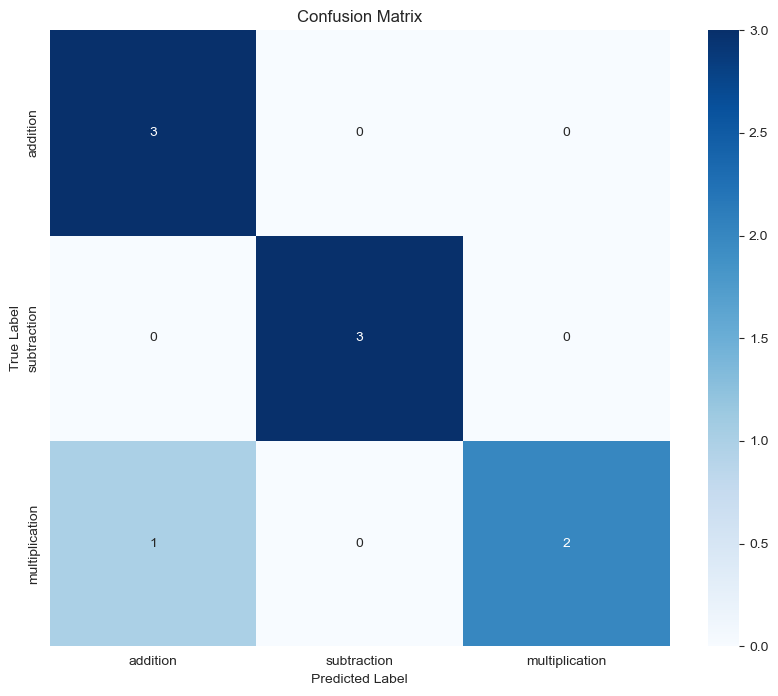

In [20]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5, 2.5], ['addition', 'subtraction', 'multiplication'])
plt.yticks([0.5, 1.5, 2.5], ['addition', 'subtraction', 'multiplication'])
plt.show()

In [21]:
# Save the tokenizer
tokenizer.save_pretrained('bert_fuzzy_arithmetic_tokenizer')
print("Tokenizer saved successfully")

Tokenizer saved successfully
